In [3]:
import os
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# Set plotting defaults
sns.set_theme(style='whitegrid')

In [4]:
# USER CONFIG - change if needed
DATA_DIR = Path('Pain-Dataset')  # folder containing ID*.gdf files
OUTPUT_DIR = Path('pain_dataset_outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# expected missing IDs (from your description)
MISSING_IDS = {12, 17, 28, 29, 32, 34, 36, 42}

# channel names hint: dataset uses 24 electrodes (2 mastoids). We'll rely on the file's channel names.

# frequency bands (Hz) for bandpower
BANDS = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}


In [5]:
# Utility: find all GDF files
gdf_files = sorted(DATA_DIR.glob('ID*.gdf'))
print(f'Found {len(gdf_files)} .gdf files in {DATA_DIR.absolute()}')

# Quick check: list missing IDs from 0..43
all_ids = set()
for f in gdf_files:
    name = f.stem  # e.g., 'ID0'
    try:
        num = int(''.join(filter(str.isdigit, name)))
        all_ids.add(num)
    except Exception:
        pass
print('IDs present:', sorted(all_ids))

Found 37 .gdf files in c:\Users\User\Desktop\TCS-PROJECTS\Project-1-EEG-SIGNALS-PAIN\Pain-Dataset
IDs present: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 33, 35, 37, 38, 39, 40, 41, 43, 151]


In [6]:
# Function: read single GDF and extract basic metadata
def read_gdf_metadata(filepath, preload=False):
    """Read .gdf using mne and return raw object and metadata dict.
    preload=False will avoid loading full data into memory.
    """
    try:
        raw = mne.io.read_raw_gdf(str(filepath), preload=preload, verbose='ERROR')
    except Exception as e:
        print(f'Error reading {filepath}: {e}')
        return None, {'error': str(e)}

    info = raw.info
    sfreq = info['sfreq']
    ch_names = info['ch_names']
    n_channels = len(ch_names)
    n_samples = raw.n_times
    duration_sec = n_samples / sfreq

    metadata = {
        'file': str(filepath),
        'sfreq': sfreq,
        'n_channels': n_channels,
        'n_samples': n_samples,
        'duration_sec': duration_sec,
        'ch_names': ch_names,
        'annotations': raw.annotations.description if raw.annotations is not None else None,
    }
    return raw, metadata

In [7]:
# Read metadata for all files (no preload) to build overview table
records = []
raw_cache = {}  # store small Raw objects if needed later with preload=True
for f in gdf_files:
    raw, meta = read_gdf_metadata(f, preload=False)
    if meta is None:
        continue
    records.append(meta)

meta_df = pd.DataFrame(records)
meta_df.to_csv(OUTPUT_DIR / 'files_metadata.csv', index=False)
meta_df

,file,sfreq,n_channels,n_samples,duration_sec,ch_names,annotations
0,Pain-Dataset\ID0.gdf,250.0,24,149952,599.808,"[FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[33024, 33025]"
1,Pain-Dataset\ID1.gdf,250.0,24,151456,605.824,"[FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[33024, 33025, 33029]"
2,Pain-Dataset\ID10.gdf,250.0,24,151488,605.952,"[FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[33024, 33025, 33029]"
3,Pain-Dataset\ID11.gdf,250.0,24,151456,605.824,"[FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[33024, 33025, 33029]"
4,Pain-Dataset\ID13.gdf,250.0,24,151456,605.824,"[FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[33024, 33025, 33029]"
5,Pain-Dataset\ID14.gdf,250.0,24,151456,605.824,"[FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[33024, 33025, 33029]"
6,Pain-Dataset\ID15(1).gdf,250.0,24,151456,605.824,"[FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[33024, 33025, 33029]"
7,Pain-Dataset\ID15.gdf,250.0,24,151456,605.824,"[FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[33024, 33025, 33029]"
8,Pain-Dataset\ID16.gdf,250.0,24,151456,605.824,"[FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[33024, 33025, 33029]"
9,Pain-Dataset\ID18.gdf,250.0,24,151456,605.824,"[FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[33024, 33025, 33029]"


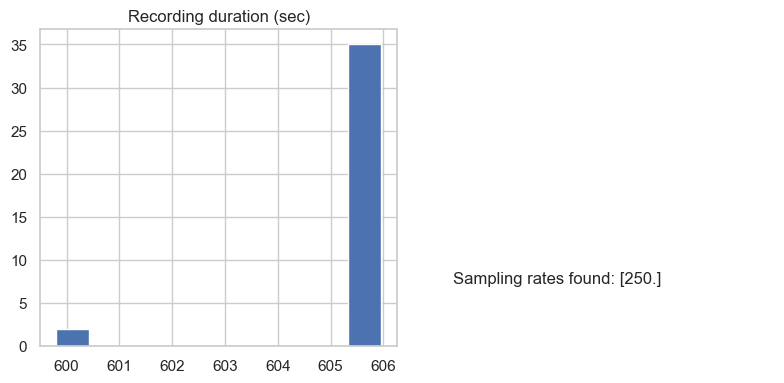

In [8]:
# Quick summary plots: distribution of durations and sampling rates
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
meta_df['duration_sec'].astype(float).hist(bins=10)
plt.title('Recording duration (sec)')
plt.subplot(1,2,2)
meta_df['sfreq'].astype(float).unique()
plt.text(0.1, 0.2, f"Sampling rates found: {meta_df['sfreq'].unique()}")
plt.axis('off')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'duration_and_sfreq.png')
plt.show()

In [9]:
# Helper: pick a subject to inspect in-depth (first available)
if len(gdf_files) == 0:
    raise FileNotFoundError('No GDF files found. Make sure DATA_DIR is correct.')

example_file = gdf_files[0]
print('Example file chosen for demonstrations:', example_file)

Example file chosen for demonstrations: Pain-Dataset\ID0.gdf


In [10]:
# Load example file with preload (we will crop first 5 seconds as recommended)
raw_example, meta_example = read_gdf_metadata(example_file, preload=True)
print(meta_example)

# Crop beginning extra 5 seconds
raw_example.crop(tmin=5.0, tmax=None)
print(f'After cropping: duration = {raw_example.n_times/raw_example.info["sfreq"]:.2f} sec')


{'file': 'Pain-Dataset\\ID0.gdf', 'sfreq': 250.0, 'n_channels': 24, 'n_samples': np.int64(149952), 'duration_sec': np.float64(599.808), 'ch_names': ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'M1', 'M2', 'AFz', 'CPz', 'POz'], 'annotations': array(['33024', '33025'], dtype='<U5')}
After cropping: duration = 594.81 sec


Using matplotlib as 2D backend.


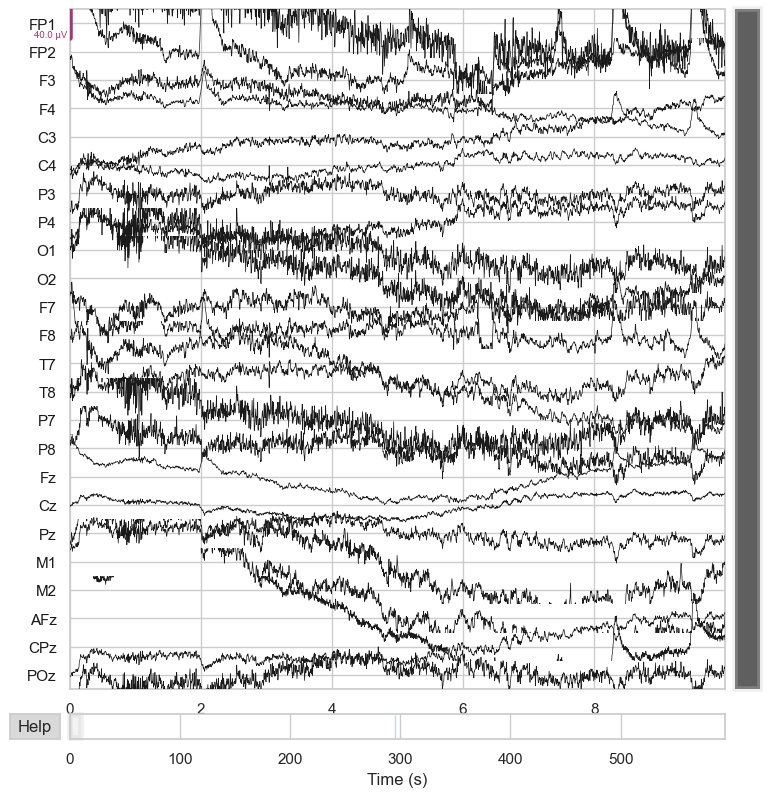

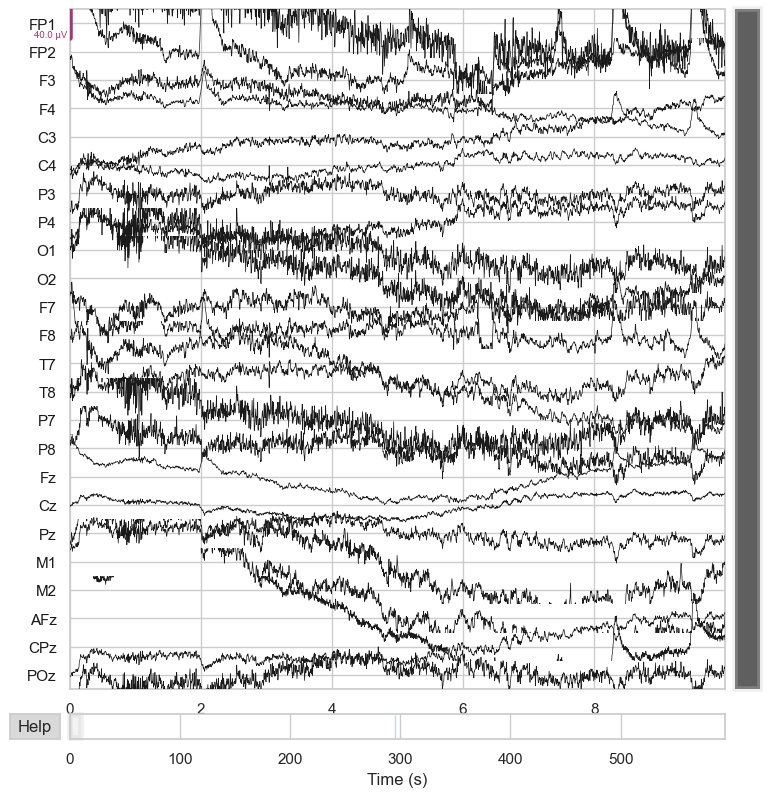

In [11]:
# Basic signal plot (first 10 seconds)
start = 0
stop = min(10, raw_example.times[-1])
raw_example.plot(start= start, duration=stop-start, n_channels=24, show=True)
# The interactive plot will open in a supported environment. For static PNG, use the next cell.


In [12]:
# Save static plot of first channel set (matplotlib)
fig = raw_example.plot(show=False)
fig.savefig(OUTPUT_DIR / f'{example_file.stem}_raw_plot.png')
plt.close(fig)


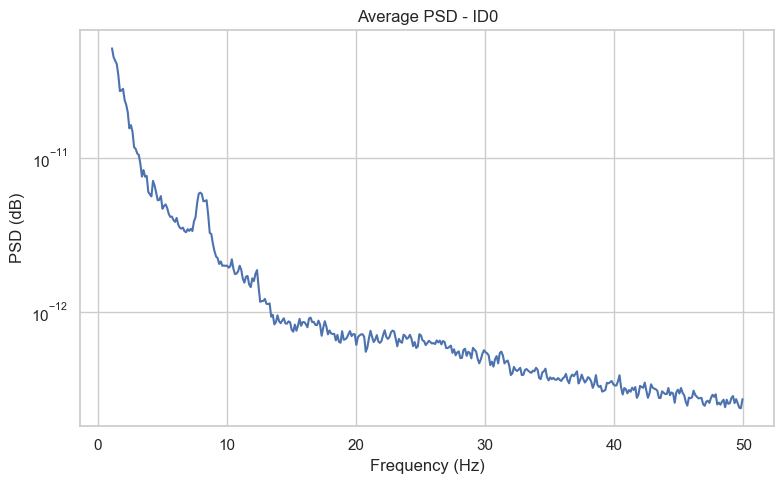

In [13]:


# Power spectral density (Welch) for all channels
psd = raw_example.compute_psd(method='welch', fmin=1, fmax=50, n_fft=2048, verbose='ERROR')
psds, freqs = psd.get_data(return_freqs=True)
psds_db = 10 * np.log10(psds)

plt.figure(figsize=(8,5))
plt.semilogy(freqs, psds.mean(axis=0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')
plt.title(f'Average PSD - {example_file.stem}')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f'{example_file.stem}_psd.png')
plt.show()


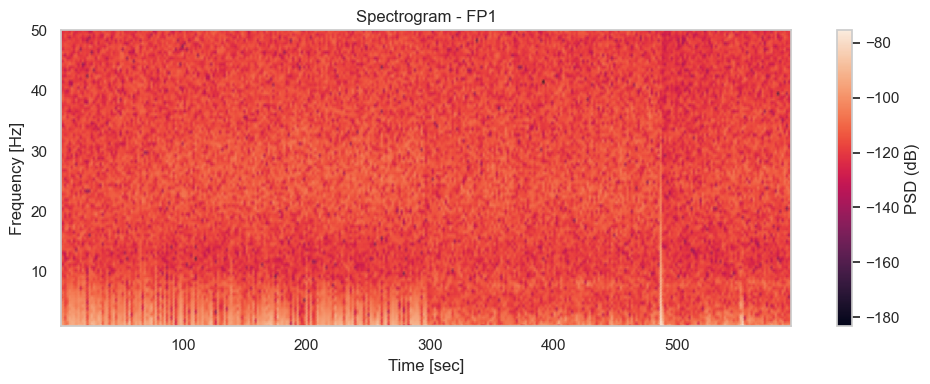

In [14]:
# Spectrogram for a single representative channel (e.g., channel 0)
ch_idx = 0
data, times = raw_example[ch_idx, :]
f, t, Sxx = signal.spectrogram(data.squeeze(), fs=raw_example.info['sfreq'], nperseg=512)
plt.figure(figsize=(10,4))
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title(f'Spectrogram - {raw_example.ch_names[ch_idx]}')
plt.ylim(1, 50)
plt.colorbar(label='PSD (dB)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / f'{example_file.stem}_spectrogram_ch{ch_idx}.png')
plt.show()

In [15]:
# Band power calculation helper
def bandpower(data, sf, band, method='welch'):
    """Compute average band power (dB) for data array (n_samples,)"""
    fmin, fmax = band
    f, Pxx = signal.welch(data, fs=sf, nperseg=1024)
    # integrate PSD in band
    idx_band = np.logical_and(f >= fmin, f <= fmax)
    bp = np.trapz(Pxx[idx_band], f[idx_band])
    return 10*np.log10(bp)

# compute band powers for all channels in example
sf = raw_example.info['sfreq']
bandpowers = {b: [] for b in BANDS}
for ch in range(raw_example.info['nchan']):
    chdata = raw_example.get_data(picks=[ch]).squeeze()
    for b, rng in BANDS.items():
        bandpowers[b].append(bandpower(chdata, sf, rng))

bp_df = pd.DataFrame(bandpowers, index=raw_example.ch_names)
bp_df.to_csv(OUTPUT_DIR / f'{example_file.stem}_bandpowers.csv')
print(bp_df.head())

          delta       theta       alpha        beta       gamma
FP1  -94.008784 -100.816112 -105.786560 -100.537099 -102.718081
FP2  -95.155872 -103.145041 -109.605155 -109.478681 -112.452451
F3  -109.326289 -112.398638 -114.450830 -111.812659 -115.475146
F4  -108.336065 -112.926473 -115.153454 -117.149702 -122.013392
C3  -112.747948 -113.361581 -115.195290 -115.857653 -121.384611


In [16]:
# Topomap of band power (requires montage / channel positions). We'll try to set a standard 10-20 montage.
try:
    # try to set standard montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw_tmp = raw_example.copy()
    raw_tmp.set_montage(montage, match_case=False, on_missing='warn')

    # compute evoked-like object for band (average across time)
    for band_name, rng in BANDS.items():
        powers = np.array([bandpowers[band_name]])[0]
        # create an info object and Evoked-like array for plotting topomap
        info = raw_tmp.info
        # create a fake evoked object
        evoked = mne.EvokedArray(powers.reshape(-1,1), info, tmin=0.)
        fig = evoked.plot_topomap(times=0., show=False)
        fig.savefig(OUTPUT_DIR / f'{example_file.stem}_topomap_{band_name}.png')
        plt.close(fig)
    print('Topomaps saved (if channel positions matched).')
except Exception as e:
    print('Topomap generation error (likely missing montage info):', e)

Topomaps saved (if channel positions matched).


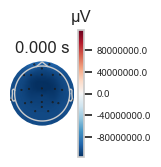

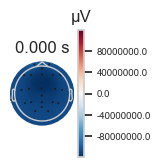

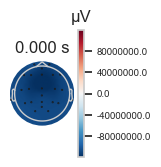

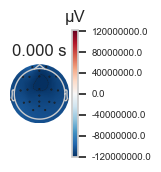

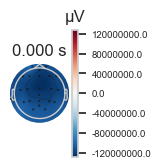

Topomaps displayed (if channel positions matched).


In [17]:
# Topomap of band power (requires montage / channel positions). We'll try to set a standard 10-20 montage.
try:
    # try to set standard montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw_tmp = raw_example.copy()
    raw_tmp.set_montage(montage, match_case=False, on_missing='warn')

    # compute evoked-like object for band (average across time)
    for band_name, rng in BANDS.items():
        powers = np.array([bandpowers[band_name]])[0]
        # create an info object and Evoked-like array for plotting topomap
        info = raw_tmp.info
        # create a fake evoked object
        evoked = mne.EvokedArray(powers.reshape(-1, 1), info, tmin=0.)
        fig = evoked.plot_topomap(times=0., show=False)
        
        # Show the figure in the notebook output
        plt.show(fig) 
        plt.close(fig)  # Close the figure to avoid cluttering with multiple plots

    print('Topomaps displayed (if channel positions matched).')
except Exception as e:
    print('Topomap generation error (likely missing montage info):', e)


Channel names before rename: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'M1', 'M2', 'AFz', 'CPz', 'POz']
Renaming channels: {'Fp1': 'Fp1', 'Fp2': 'Fp2'}
 Montage set successfully with 'standard_1020'
Fitting ICA to data using 24 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.8s.


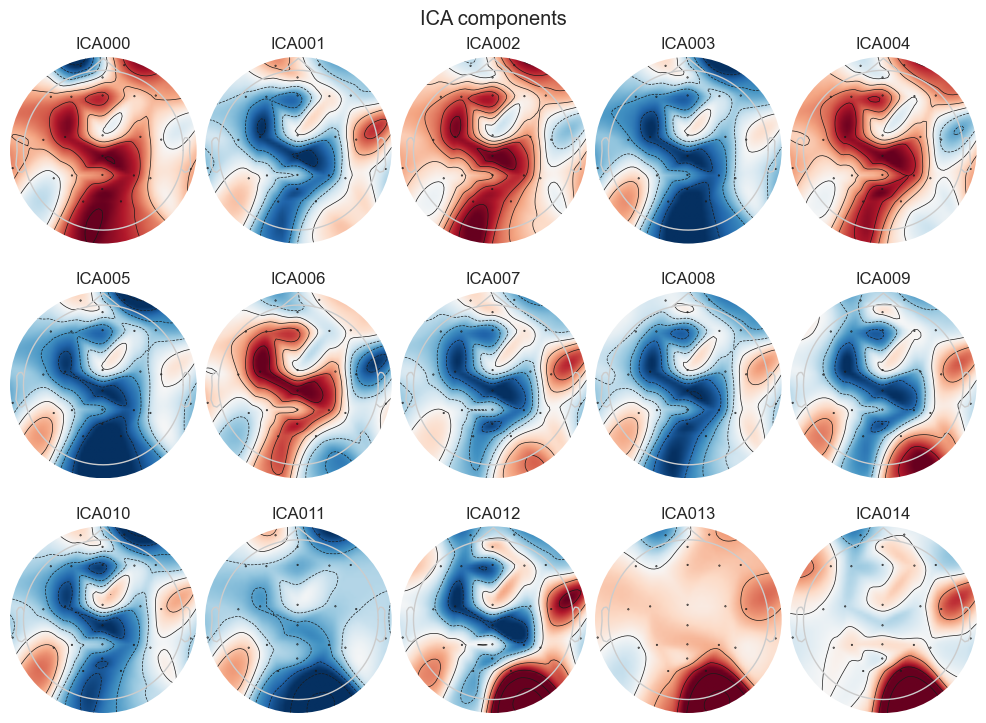

✅ ICA components plotted and saved successfully.


In [19]:


import mne
import matplotlib.pyplot as plt
from pathlib import Path

# Define output directory
OUTPUT_DIR = Path("pain_dataset_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# ---- Load your example raw file ----
# Example: raw_example = mne.io.read_raw_fif("your_file.fif", preload=True)
# (Assuming 'raw_example' is already loaded)

# Print all channel names to verify
print("Channel names before rename:", raw_example.ch_names)

# --- Step 1: Fix montage naming mismatches (FP1, FP2 → Fp1, Fp2) ---
rename_dict = {}
for ch in raw_example.ch_names:
    if ch.upper() == 'FP1':
        rename_dict[ch] = 'Fp1'
    elif ch.upper() == 'FP2':
        rename_dict[ch] = 'Fp2'

if rename_dict:
    print("Renaming channels:", rename_dict)
    raw_example.rename_channels(rename_dict)

# --- Step 2: Set standard 10-20 montage safely ---
try:
    raw_example.set_montage('standard_1020', on_missing='ignore')
    print(" Montage set successfully with 'standard_1020'")
except Exception as e:
    print(" Montage assignment issue:", e)

# --- Step 3: Run ICA for artifact detection ---
ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter='auto')
ica.fit(raw_example)

# --- Step 4: Plot ICA components (interactive + saved image) ---
ica.plot_components()  # Opens interactive window

# Save components grid image
fig = ica.plot_components(show=False)
example_file = Path("raw_example_data")  # Replace with your filename stem
fig.savefig(OUTPUT_DIR / f'{example_file.stem}_ica_components.png')
plt.close(fig)

print("✅ ICA components plotted and saved successfully.")


In [20]:
# OPTIONAL: Automatically find EOG-like components by correlation to frontal channels (if present)
frontal_candidates = []
for ch in raw_example.ch_names:
    if 'Fp' in ch or 'AF' in ch or 'Fz' in ch:
        frontal_candidates.append(ch)

if frontal_candidates:
    print('Frontal channels found:', frontal_candidates)
else:
    print('No clear frontal channels found; auto EOG detection may fail.')


Frontal channels found: ['Fp1', 'Fp2', 'Fz', 'AFz']


In [21]:
# Batch processing function: compute summary metrics for each file and save CSV
def summarize_all_files(gdf_files, out_csv=OUTPUT_DIR / 'dataset_summary.csv'):
    rows = []
    for f in gdf_files:
        raw, meta = read_gdf_metadata(f, preload=True)
        if meta.get('error'):
            rows.append({**{'file': str(f), 'error': meta['error']}})
            continue
        # crop first 5 seconds
        raw.crop(tmin=5.0, tmax=None)
        sf = raw.info['sfreq']
        duration = raw.n_times / sf
        # compute average RMS per channel
        data = raw.get_data()
        rms = np.sqrt(np.mean(data**2, axis=1))
        avg_rms = np.mean(rms)
        # bandpower per channel (alpha mean)
        alpha_vals = []
        for ch in range(raw.info['nchan']):
            chdata = raw.get_data(picks=[ch]).squeeze()
            alpha_vals.append(bandpower(chdata, sf, BANDS['alpha']))
        rows.append({
            'file': str(f),
            'sfreq': sf,
            'n_channels': raw.info['nchan'],
            'duration_sec': duration,
            'avg_rms': avg_rms,
            'alpha_mean_db': np.mean(alpha_vals)
        })
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    return df

summary_df = summarize_all_files(gdf_files)
summary_df.head()

,file,sfreq,n_channels,duration_sec,avg_rms,alpha_mean_db
0,Pain-Dataset\ID0.gdf,250.0,24,594.808,0.013771,-111.050142
1,Pain-Dataset\ID1.gdf,250.0,24,600.824,0.006474,-108.918105
2,Pain-Dataset\ID10.gdf,250.0,24,600.952,0.008573,-92.138158
3,Pain-Dataset\ID11.gdf,250.0,24,600.824,0.004199,-113.359745
4,Pain-Dataset\ID13.gdf,250.0,24,600.824,0.005912,-112.819793


In [42]:
import os
import mne
import matplotlib.pyplot as plt

# Path to folder containing GDF files
DATA_PATH = "Pain-Dataset"  # <-- change if needed

def load_gdf(subject_id):
    """Load a GDF file and its annotations."""
    gdf_path = os.path.join(DATA_PATH, f"{subject_id}.gdf")
    if not os.path.exists(gdf_path):
        raise FileNotFoundError(f"GDF file not found: {gdf_path}")
    
    raw = mne.io.read_raw_gdf(gdf_path, preload=True, verbose=False)
    ann = raw.annotations if raw.annotations is not None else None
    sfreq = raw.info["sfreq"]
    
    print(f"Processing file: {subject_id}")
    print(f"Sampling rate: {sfreq}")
    print(f"Channels: {raw.ch_names[:6]} ...")
    if ann is not None:
        print(ann)
        for onset, dur, desc in zip(ann.onset, ann.duration, ann.description):
            print(f"onset(s)={onset:.3f}, dur={dur:.3f}, desc={desc}")
    print("-" * 40)
    
    return raw, ann, sfreq


def plot_with_annotation_lines(raw, subject_id, channel="C3", t_start=0, t_duration=30):
    """Plot EEG signal and show dashed lines where annotation changes occur."""
    sfreq = raw.info["sfreq"]
    ch_idx = raw.ch_names.index(channel)
    
    # Extract the requested time segment
    start_sample = int(t_start * sfreq)
    stop_sample = int((t_start + t_duration) * sfreq)
    data, times = raw[ch_idx, start_sample:stop_sample]
    
    # Decide the annotation boundary times manually (based on file ID)
    if subject_id in ["ID0", "ID26"]:
        boundaries = [0, 300]
    else:
        boundaries = [5, 305, 605]
    
    plt.figure(figsize=(12, 4))
    plt.plot(times, data[0], color="k", label=channel)
    
    # Draw lines only if boundaries fall inside current window
    for b in boundaries:
        if t_start <= b <= t_start + t_duration:
            plt.axvline(x=b, color="r", linestyle="--", label=f"Annotation change ({b}s)")
    
    plt.title(f"{subject_id}: {channel} signal with annotation change markers")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()



In [43]:


# ===========================
# Example usage 
# ===========================

raw, ann, sfreq = load_gdf("ID1")  # change to ID0, ID26, etc. to test
print("Channels:", raw.ch_names)
print("Sampling rate:", sfreq)
print("Annotations:", ann.description if ann else "None")


Processing file: ID1
Sampling rate: 250.0
Channels: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4'] ...
<Annotations | 3 segments: 33024 (1), 33025 (1), 33029 (1)>
onset(s)=5.000, dur=0.004, desc=33024
onset(s)=305.000, dur=0.004, desc=33025
onset(s)=605.000, dur=0.004, desc=33029
----------------------------------------
Channels: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'M1', 'M2', 'AFz', 'CPz', 'POz']
Sampling rate: 250.0
Annotations: ['33024' '33025' '33029']


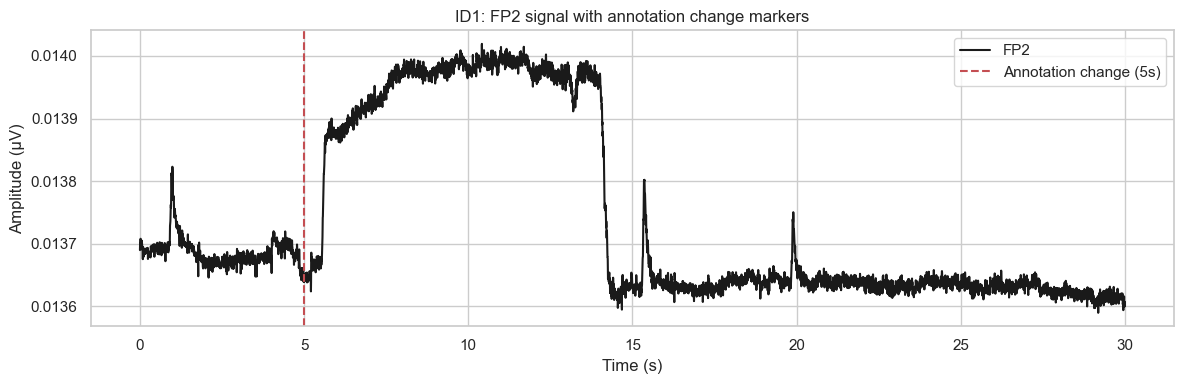

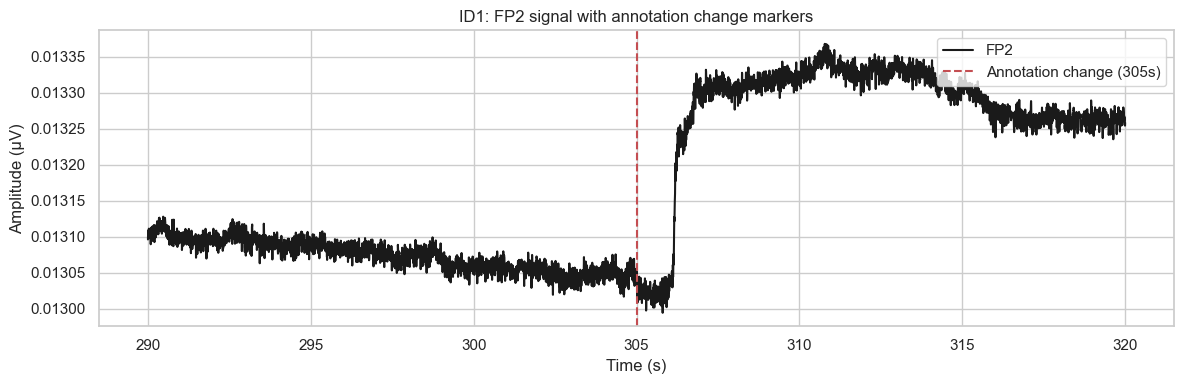

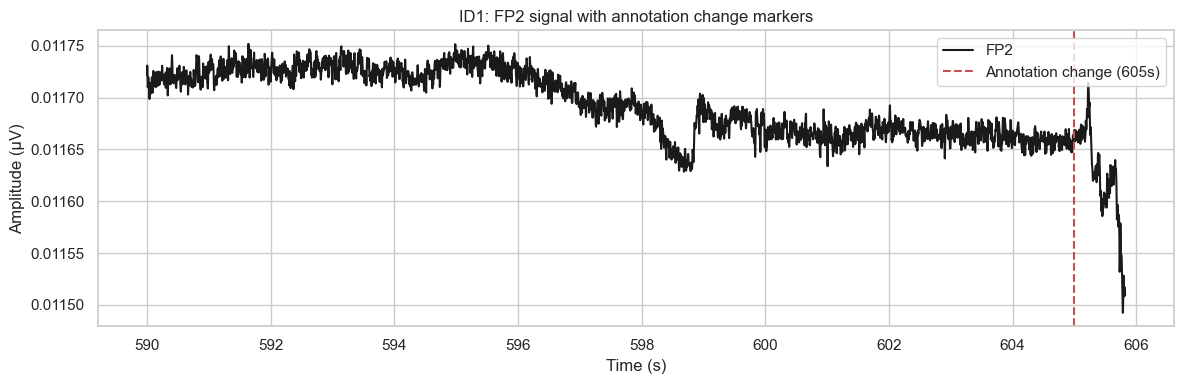

In [44]:
# For ID1 which has 3 annotations changes at 5s and 305s and 605s 
plot_with_annotation_lines(raw, "ID1", channel=raw.ch_names[1], t_start=0, t_duration=30)
plot_with_annotation_lines(raw, "ID1", channel=raw.ch_names[1], t_start=290, t_duration=30)
plot_with_annotation_lines(raw, "ID1", channel=raw.ch_names[1], t_start=590, t_duration=30)

Processing file: ID26
Sampling rate: 250.0
Channels: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4'] ...
<Annotations | 2 segments: 33024 (1), 33025 (1)>
onset(s)=0.000, dur=0.004, desc=33024
onset(s)=300.000, dur=0.004, desc=33025
----------------------------------------
Channels: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'M1', 'M2', 'AFz', 'CPz', 'POz']
Sampling rate: 250.0
Annotations: ['33024' '33025']


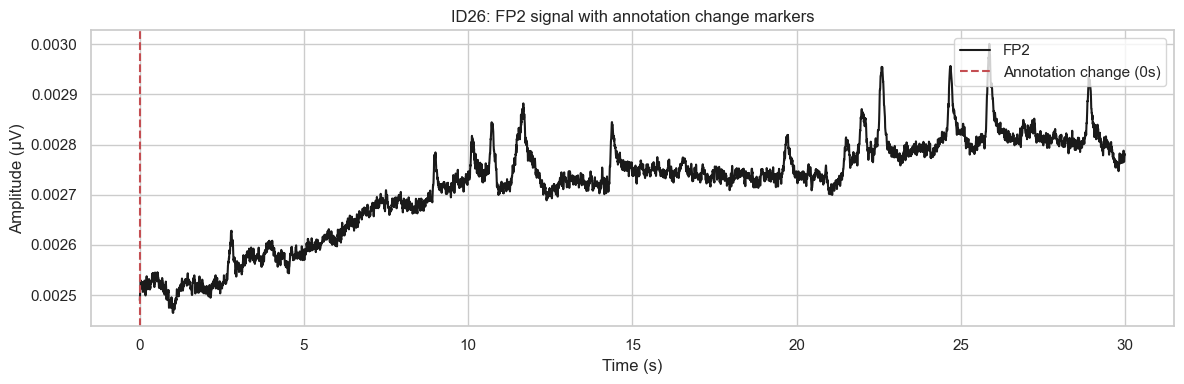

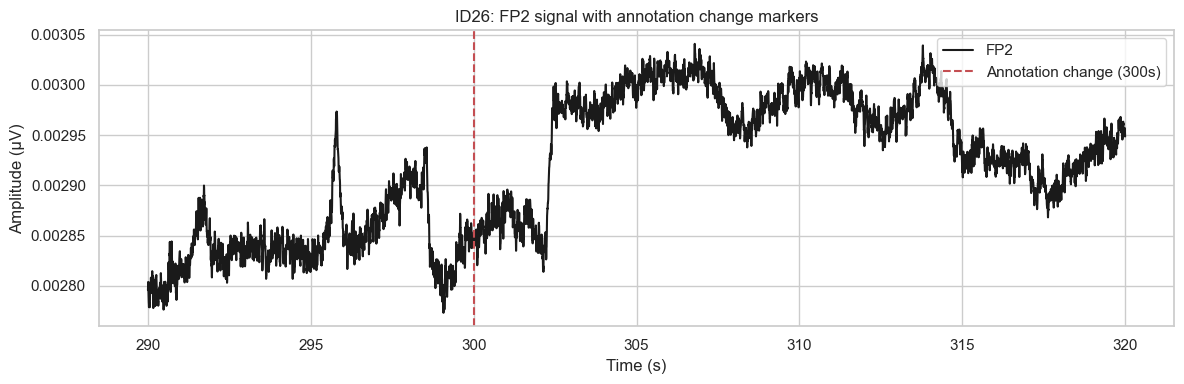

In [45]:
raw, ann, sfreq = load_gdf("ID26") 
print("Channels:", raw.ch_names)
print("Sampling rate:", sfreq)
print("Annotations:", ann.description if ann else "None")


# For ID26 which has 2 annotations changes at 0s and 300s
plot_with_annotation_lines(raw, "ID26", channel=raw.ch_names[1], t_start=0, t_duration=30)
plot_with_annotation_lines(raw, "ID26", channel=raw.ch_names[1], t_start=290, t_duration=30)